Contact: JB Daudet (jean-baptiste.daudet@proximity.fr)

Creation date: 22/05/2024

Last modification date: 29/05/2024


Description:
  Capture data around how people are doing their chores

Outputs:
  TBD

In [1]:
#Local version of the file containing the secret key
import gitignore as g

In [2]:
openai_api_key = g.openai_api_key
spotify_clientID = g.spotify_clientID
spotify_clientSecret = g.spotify_clientSecret

### IMPORTS

In [3]:
# Import the necessary libraries

import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=Warning)
from IPython.display import display, HTML, Markdown
import spotify.sync as spotify  # Nothing requires async/await now!
pd.set_option('max_colwidth', 400)

import requests 
import time

import spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from openai import OpenAI

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures


# Get the list of playlists:

In [ ]:
# capture the playlists: do not re-run if not necessary!

client = spotify.Client(spotify_clientID, spotify_clientSecret)

playlists = []

for i in range(100):
    j = i *10
    results = await client.search('chores', types=['playlist'], limit=10, offset=j)
    playlists.extend(results.playlists)
    time.sleep(10)

#save playlists
with open("playlists.txt", 'w') as f:
    for pl in playlists:
        f.write(str(pl) + '\n')

In [ ]:
#load saved playlists
with open("playlists.txt", 'r') as f:
    playlists = [line.rstrip('\n').split(':')[2] for line in f]

print(playlists)
len(playlists)

# Capturing the list & description of the songs in the playlists (first 20 tracks only) 

In [6]:
# Instantiate connection to the Spotipy api: 

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=spotify_clientID,
                                                           client_secret=spotify_clientSecret),
                                                           retries=0)

In [ ]:

# Function to fetch tracks from a playlist
def get_playlist_tracks(playlist_id, limit=20):
    tracks = []
    playlist_info = sp.playlist(playlist_id)
    results = sp.playlist_tracks(playlist_id, limit=limit)
    
    track_ids = [item['track']['id'] for item in results['items']]
    track_info_list = sp.tracks(track_ids)['tracks']
    
    album_ids = list(set([track['album']['id'] for track in track_info_list]))
    artist_ids = list(set([track['artists'][0]['id'] for track in track_info_list]))
    
    album_info_list = sp.albums(album_ids)['albums']
    artist_info_list = sp.artists(artist_ids)['artists']
    
    album_info_dict = {album['id']: album for album in album_info_list}
    artist_info_dict = {artist['id']: artist for artist in artist_info_list}
    
    audio_features_list = sp.audio_features(track_ids)
    audio_features_dict = {af['id']: af for af in audio_features_list}

    for track in track_info_list:
        album = album_info_dict[track['album']['id']]
        artist = artist_info_dict[track['artists'][0]['id']]
        audio_features = audio_features_dict[track['id']]
        
        track_info = {
            'playlist_id': playlist_id,
            'playlist_name': playlist_info['name'],
            'playlist_description': playlist_info['description'],
            'playlist_num_tracks': playlist_info['tracks']['total'],
            'playlist_num_followers': playlist_info['followers']['total'],
            'track_id': track['id'],
            'track_name': track['name'],
            'album_release_date': album['release_date'],
            'artist_genre': artist['genres'][0] if artist['genres'] else None,
        }
        track_info.update(audio_features)
        tracks.append(track_info)

    return tracks

In [ ]:
# Create empty DataFrame
columns = ['playlist_id', 'playlist_name', 'playlist_description', 'playlist_num_tracks', 'playlist_num_followers', 'track_id', 'track_name', 'album_release_date', 'artist_genre']

# Add audio feature columns to the DataFrame
audio_feature_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature']
columns.extend(audio_feature_columns)
df = pd.DataFrame(columns=columns)


In [ ]:
# load data into the dataframe: 

pl_num=0

# Fetch tracks from each playlist with rate limiting
for playlist_id in playlists:
    
    pl_num = pl_num + 1
    if not pl_num % 10:
        print("playlist n°", pl_num, '/',len(playlists) )
    try:
        tracks = get_playlist_tracks(playlist_id)
        df = pd.concat([df, pd.DataFrame(tracks)], ignore_index=True)
        time.sleep(1)  # introduce a 1-second delay between processing each playlist
    except Exception as e:
        print(f"An error occurred: {e}")
        time.sleep(60)  # wait for 1 minute before retrying in case of an error


In [ ]:
# Save dataframe to Pickle
df.to_pickle('playlist_tracks.pkl')

In [ ]:
already_done = list(set(df['playlist_id'].to_list()))
playlists = [pl for pl in playlists if pl not in already_done]

In [ ]:
# Enrichment of the playlists with tracks features:
        
pl_num = 0

for playlist in playlists:
    print(playlist)
    pl_num = pl_num + 1
    print("playlist n°", pl_num, '/',len(playlists) )
    playlist_length = len(sp.playlist(playlist)['tracks']['items'])
    print(playlist_length)
    playlist_followers = sp.playlist(playlist)['followers']['total']
    playlist_name = sp.playlist(playlist)['name']
    playlist_desc = sp.playlist(playlist)['description']
    print(playlist_desc)

    for i in range(min(playlist_length, 10)):

            track_id = sp.playlist(playlist)['tracks']['items'][i]["track"]['id']
            artist_id = sp.playlist(playlist)['tracks']['items'][i]["track"]["artists"][0]['id']
            try: 
                style  = sp.artist(artist_id)['genres'][0]
            except: 
                style='unknown'
            release_date = sp.playlist(playlist)['tracks']['items'][i]["track"]['album']['release_date']

            track_desc = sp.audio_features(track_id)[0]
            track_desc['track_id'] = track_id
            track_desc['style'] = style
            track_desc['release_date'] = release_date
            
            track_desc['playlist_id'] = playlist
            track_desc['playlist_length'] =playlist_length
            track_desc['playlist_followers'] = playlist_followers
            track_desc['playlist_name'] = playlist_name
            track_desc['playlist_name'] = playlist_name
            track_desc['playlist_desc'] = playlist_desc

            df = pd.concat([df,pd.DataFrame([track_desc])], ignore_index=True)
    
    time.sleep(1)

In [ ]:
# In case the process fails at some point, remove last playlist (in process) and save.
last_playlist_to_remove = df.iloc[-1]['playlist_id']
df = df[df['playlist_id']!=last_playlist_to_remove]

# Save dataframe to Pickle
df.to_pickle('playlist_tracks.pkl')

# Regrouping music styles 

In [ ]:
# load from pickle
df_tracks = pd.read_pickle("playlist_tracks.pkl")

In [4]:
# instantiation of ChatGPT:
client = OpenAI(api_key=openai_api_key)

In [ ]:

# Function to get the closest generic style for a given genre
def get_generic_style(genre):
    while True:
        try:
            response = client.chat.completions.create(
                model="gpt-4-turbo",
                messages=[{'role':'user', 'content':f"Find the closest mainstream music style to: {genre}. Limit your answer to returning ONE of the following options, without adding any other word or punctuation of any kind: Classical, Jazz/Blues, Rock/Metal, Pop, Rap/Hip Hop, Folk/Country, R&B/Soul, Reggae/Dub, Electronic, Latin, World Music, Alternative/Indie"}]
            )
            return response.choices[0].message.content
        except:
            time.sleep(10)

def process_genre(genre):
    try:
        return genre, get_generic_style(genre)
    except Exception as e:
        return genre, str(e)

def compute_music_genre_recateg(music_genres):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_genre, music_genres))
    return dict(results)

In [ ]:
music_genres =list(set( df_tracks['artist_genre'].to_list()))
len(music_genres)

In [ ]:
music_genres_dict = compute_music_genre_recateg(music_genres)

In [ ]:
# Apply the function to the artist_genre column
df_tracks['generic_genre'] = df_tracks['artist_genre'].apply(lambda x: music_genres_dict[x])
list(set(df_tracks.generic_genre.to_list()))


In [ ]:
# change some mistakes done by chatGPT:
df_tracks['generic_genre'] = np.where(df_tracks['generic_genre'].str.contains('Rock'),'Rock/Metal',
                                      np.where(df_tracks['generic_genre'].str.contains('Alternative'), "Alternative/Indie",
                                               np.where(df_tracks['generic_genre'].str.contains('Reggae'), "Reggae/Dub",
                                                        df_tracks['generic_genre'])))

df_tracks.generic_genre.value_counts()

In [ ]:
# Save dataframe to Pickle
df_tracks.to_pickle('playlist_save_final.pkl')

# Clustering of the playlists

https://www.kaggle.com/code/sivarazadi/k-means-spotify-song-clustering

In [7]:
# load from pickle
df_tracks = pd.read_pickle("playlist_save_final.pkl")

### Formatting of the variables

In [8]:

# release date :

# Select a subset of columns to use in the clustering process
df_tracks['release_year']  = df_tracks['album_release_date'].apply(lambda x: int(x[:4]))

# Define the bins and labels
bins = [1900, 2000, 2020, 2025]  # Adjust the bins as needed
labels = ['old', 'mid', 'recent']

df_tracks['year_category'] = pd.cut(df_tracks['release_year'], bins=bins, labels=labels, right=False)

# Convert the bins to dummy variables
df_years = pd.get_dummies(df_tracks['year_category'], prefix='release')

# Concatenate the dummy variables with the original DataFrame
df_tracks = pd.concat([df_tracks, df_years], axis=1)

# Drop the original 'year_category' column if no longer needed
df_tracks.drop(columns=['year_category'], inplace=True)


In [9]:

# One-Hot Encode the generic genres
df_genres = df_tracks['generic_genre'].str.get_dummies(sep=', ')

# Combine the genre columns with the original dataframe
df_tracks = pd.concat([df_tracks, df_genres], axis=1)

# Select relevant columns for clustering
features = ['playlist_id','danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

df_tracks_features = df_tracks[features]
df_tracks_features.set_index('playlist_id', inplace=True)

# Normalize the values of each column
df_tracks_features = (df_tracks_features - df_tracks_features.mean()) / df_tracks_features.std()
df_tracks_features.reset_index(inplace=True)
df_tracks_features.head()


,playlist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,2iREaTgLfnAjzWxv1lhbw9,1.155250,0.951890,0.738923,1.196574,0.365137,-0.293507,2.523598,0.363058,-0.749360
1,2iREaTgLfnAjzWxv1lhbw9,0.633793,0.896032,0.644317,-0.379579,-0.517299,-0.293350,-0.539248,0.994557,0.027571
2,2iREaTgLfnAjzWxv1lhbw9,1.175052,0.728459,0.451842,-0.288190,-0.792597,-0.293708,2.748707,0.560928,0.273890
3,2iREaTgLfnAjzWxv1lhbw9,1.320268,0.342533,0.424261,-0.135085,-0.701741,-0.292109,0.190651,1.432396,-0.008782
4,2iREaTgLfnAjzWxv1lhbw9,1.109045,1.556168,1.669861,0.134332,0.302747,-0.280494,1.111551,1.074547,0.273890


In [10]:

# Group by playlist and calculate mean and standard deviation for each feature, including genres
grouped_features = df_tracks_features.groupby('playlist_id').mean()
grouped_genres = df_tracks.groupby('playlist_id')[df_genres.columns].mean()
grouped_years = df_tracks.groupby('playlist_id')[df_years.columns].mean()

# Combine the grouped features and genres
grouped = pd.concat([grouped_features, grouped_genres, grouped_years], axis=1).reset_index()

# Merge with playlist metadata
playlist_meta = df_tracks[['playlist_id', 'playlist_name', 'playlist_num_followers', 'playlist_num_tracks']].drop_duplicates()
df_playlist = pd.merge(grouped, playlist_meta, how='left', on='playlist_id')


In [11]:
print(df_playlist['playlist_name'].to_list())

['Chores day', 'backyard daydream daze', 'Cleaning 🧼 🫧🧹', 'SlaveWork', 'Chores around the house', 'A playlist for a girl who loves doing chores (it makes her feel better) ', 'Chores', 'Spring Cleaning', 'Cleaning Mix', 'Songs for chores', 'Farm Chores ', 'Rock and Chores ', 'Doin Chores', 'Chores', 'Chore’s ', 'Get Chores Done', 'Dance Party Chores mix 🤘🏼💃🏼', 'chores', 'cleaning', 'Chores', 'all bangers no skips', 'cleaning', 'Cleaning Time', 'Cha Cha Chores ', 'Dishes (chores)', 'Chores', 'Cleaning', 'Snail chores', 'Get Shit Done RN', 'cleaning', 'cleaning like a kaelimae TikTok 🧼🦋', 'chores', 'Cleaning', 'Rock Music for School and Chores', 'Chores/Cleaning Time!', 'Cleaning', 'Chores', 'Cleaning Motivation 2024 🏡 Cleaning Music', 'fast cleaning dance songs', 'Moody Mosey', 'Sing along', 'aftrnoon baile ', 'Cleaning ', '210 summer chores', 'Cleaning', 'Chores', 'Cleaniing Music', 'Headphones/Chores', 'Chores', 'Chores', 'Jewish Running Playlist 2024', 'Spring Cleaning Motivational So

In [12]:

# Select features for clustering
cluster_features = ['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'Alternative/Indie', 'Classical', 'Electronic', 'Folk/Country',
       'Jazz/Blues', 'Latin', 'Pop', 'R&B/Soul', 'Rap/Hip Hop', 'Reggae/Dub',
       'Rock/Metal', 'World Music', 'release_old', 'release_mid',
       'release_recent']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(df_playlist[cluster_features])

In [13]:
# Initialize an empty list to store the sum of squared distances for each number of clusters
sse = [] 

# Fit the KMeans model to the data with a range of different numbers of clusters
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_playlist[cluster_features])
    sse.append(kmeans.inertia_)  # Add the sum of squared distances for the current number of clusters to the list

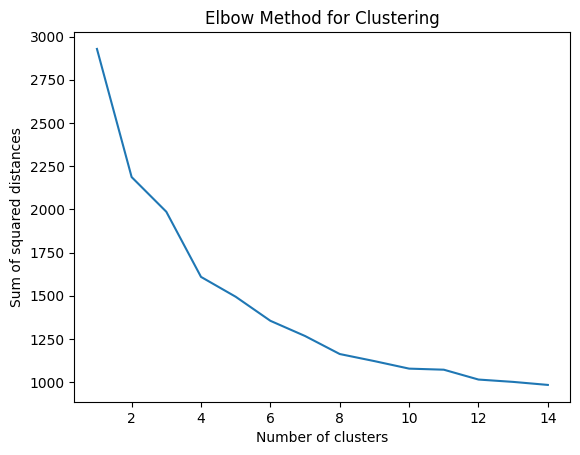

In [14]:
# Plot the sum squared distances for each number of clusters for elbow method

plt.plot(range(1, 15), sse)
plt.title('Elbow Method for Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

In [15]:
df_playlist.head()

,playlist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,Rap/Hip Hop,Reggae/Dub,Rock/Metal,World Music,release_old,release_mid,release_recent,playlist_name,playlist_num_followers,playlist_num_tracks
0,003WT12LBY9AciKBo2pjjh,-0.240253,-1.000167,-0.550742,-0.181768,0.649762,0.043381,0.164047,-0.546756,0.227448,...,0.166667,0.0,0.00,0.0,0.00,0.833333,0.166667,Chores day,0,12
1,00ioLA4pmisclZSEqGn4qd,-0.425293,-0.075130,-1.121870,-0.548172,0.792922,2.743991,0.348295,0.906358,0.054187,...,0.000000,0.0,1.00,0.0,0.95,0.050000,0.000000,backyard daydream daze,0,3567
2,02IQtGO6sGW1PE301EvGun,-0.481399,-1.071732,-0.512134,-0.004649,0.739235,-0.183362,0.000877,-0.849630,-0.001140,...,0.350000,0.0,0.05,0.0,0.05,0.400000,0.550000,Cleaning 🧼 🫧🧹,0,32
3,02wJehXLEvaVaHCtNeF53s,-0.576780,0.819355,0.553077,0.356216,-0.579563,0.143584,0.426845,-0.043837,0.356346,...,0.100000,0.0,0.45,0.0,0.05,0.550000,0.400000,SlaveWork,0,98
4,03oKLLKSMJnccDURePdaRz,0.348312,-0.582927,0.014992,0.177238,0.168381,-0.286556,-0.052058,-0.282754,-0.367209,...,0.000000,0.0,0.00,0.0,0.00,0.600000,0.400000,Chores around the house,1,357


In [16]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=8, random_state=42)  # number of clusters based on elbow rule above
df_playlist['cluster'] = kmeans.fit_predict(X)

In [17]:
sil_score = silhouette_score(X, df_playlist['cluster'])
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.14478294020077162


# Clusters analysis

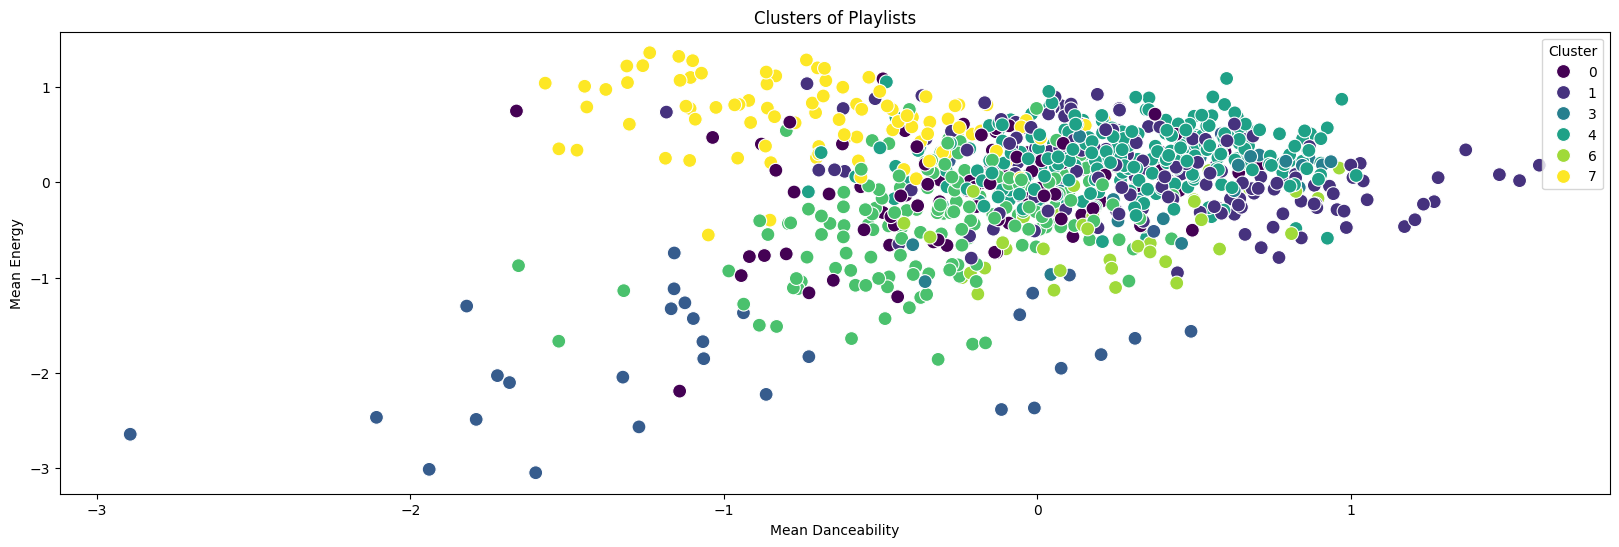

In [18]:
# Plot the clusters
plt.figure(figsize=(20, 6))
sns.scatterplot(x='danceability', y='energy', hue='cluster', data=df_playlist, palette='viridis', s=100)
plt.title('Clusters of Playlists')
plt.xlabel('Mean Danceability')
plt.ylabel('Mean Energy')
plt.legend(title='Cluster')
plt.show()


In [19]:
#number of playlists by cluster
nb_playlists =  df_playlist.cluster.value_counts().reset_index()
nb_followers = df_playlist.groupby('cluster').playlist_num_followers.sum().reset_index()
clusters_description = nb_playlists.merge(nb_followers, how='inner', on='cluster')
clusters_description.columns = ['cluster', 'nb_playlists', 'nb_followers']
clusters_description['followers_by_playlist']  = (clusters_description['nb_followers'] /clusters_description['nb_playlists']).apply(np.floor)
clusters_description.sort_values('cluster')

,cluster,nb_playlists,nb_followers,followers_by_playlist
3,0,95,336617,3543
2,1,154,1330583,8640
6,2,33,11580,350
7,3,22,983765,44716
0,4,258,220684,855
1,5,164,68418,417
5,6,38,7896,207
4,7,93,5407,58


In [20]:
clusters_description.sort_values('cluster').to_excel('clusters_description.xlsx', index=False)

In [21]:

# Now, we can examine the characteristics of the individual clusters: group the data by cluster and compute the mean of each column
cluster_means = df_playlist.select_dtypes(include='number').groupby('cluster').mean()


         danceability    energy  loudness  speechiness  acousticness  \
cluster                                                                
0           -0.178646 -0.056846 -0.514989    -0.348826      0.107664   
1            0.371230  0.101574  0.135184     0.556599     -0.192153   
2           -0.815557 -1.624497 -2.280247    -0.207661      1.768451   
3            0.456578 -0.080734  0.174869    -0.122661      0.387851   
4            0.302996  0.264838  0.365740    -0.004728     -0.288202   
5           -0.294606 -0.408434 -0.140370    -0.300695      0.438531   
6            0.235273 -0.538436 -0.371338     0.304919      0.302468   
7           -0.674233  0.652580  0.375329    -0.061132     -0.505547   

         instrumentalness  liveness   valence     tempo  
cluster                                                  
0               -0.025067  0.106732  0.431501 -0.046691  
1                0.042564  0.054159 -0.133269  0.100694  
2                2.830340 -0.219638 -0.710048 -

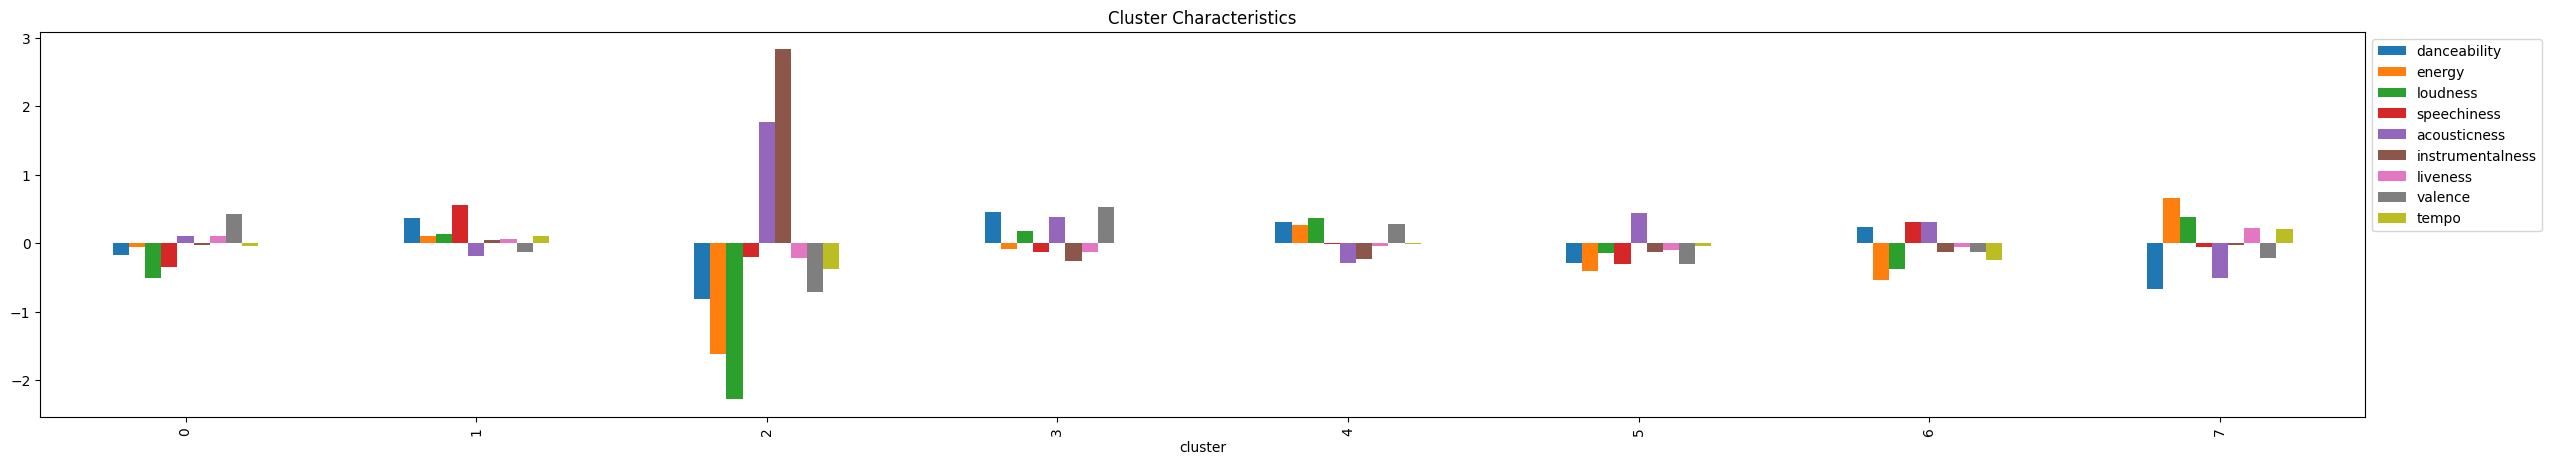

In [26]:
print(cluster_means[cluster_means.columns[:9]])

# We can also compare the clusters to each other by creating a plot of the cluster means
# This can help us to see how the clusters differ from each other
cluster_means[cluster_means.columns[:9]].plot(kind='bar')
plt.title('Cluster Characteristics')
plt.legend(bbox_to_anchor=(1.0, 1.0))

plt.rcParams['figure.figsize'] = [30, 5]
plt.show()

         Classical  Electronic  Folk/Country  Jazz/Blues     Latin       Pop  \
cluster                                                                        
0         0.030526    0.018947      0.111754    0.033158  0.008947  0.182632   
1         0.162254    0.129531      0.012513    0.003530  0.011688  0.176171   
2         0.312024    0.171830      0.028788    0.131059  0.003030  0.107839   
3         0.031818    0.002273      0.009091    0.002273  0.865107  0.015909   
4         0.033564    0.035860      0.034689    0.005039  0.015781  0.566490   
5         0.079391    0.023115      0.282200    0.008918  0.006098  0.247711   
6         0.045865    0.015789      0.010338    0.010338  0.005263  0.205075   
7         0.026971    0.023253      0.036380    0.002151  0.001075  0.095833   

         R&B/Soul  Rap/Hip Hop  Reggae/Dub  Rock/Metal  World Music  
cluster                                                              
0        0.071754     0.023158    0.005263    0.445789     

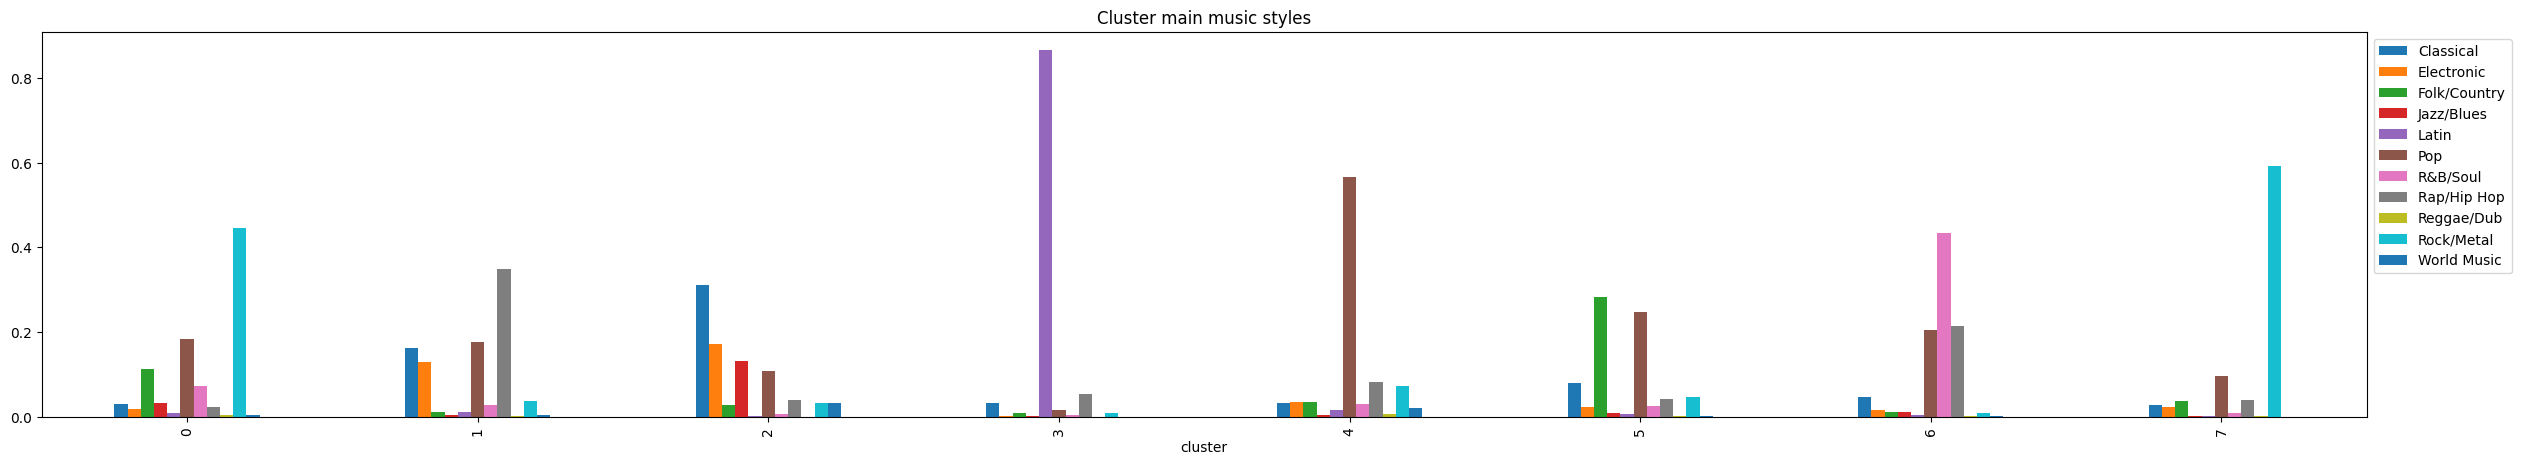

In [23]:
print(cluster_means[cluster_means.columns[10:21]])

# We can also compare the clusters to each other by creating a plot of the cluster means
# This can help us to see how the clusters differ from each other
cluster_means[cluster_means.columns[10:21]].plot(kind='bar')
plt.title('Cluster main music styles')
plt.legend(bbox_to_anchor=(1.0, 1.0))

plt.rcParams['figure.figsize'] = [30, 5]
plt.show()

         release_old  release_mid  release_recent
cluster                                          
0           0.697193     0.264912        0.037895
1           0.031313     0.379786        0.588252
2           0.134458     0.634259        0.231283
3           0.177674     0.475267        0.347059
4           0.086762     0.678933        0.234111
5           0.057121     0.501687        0.441192
6           0.196617     0.584712        0.218672
7           0.199642     0.645072        0.155287


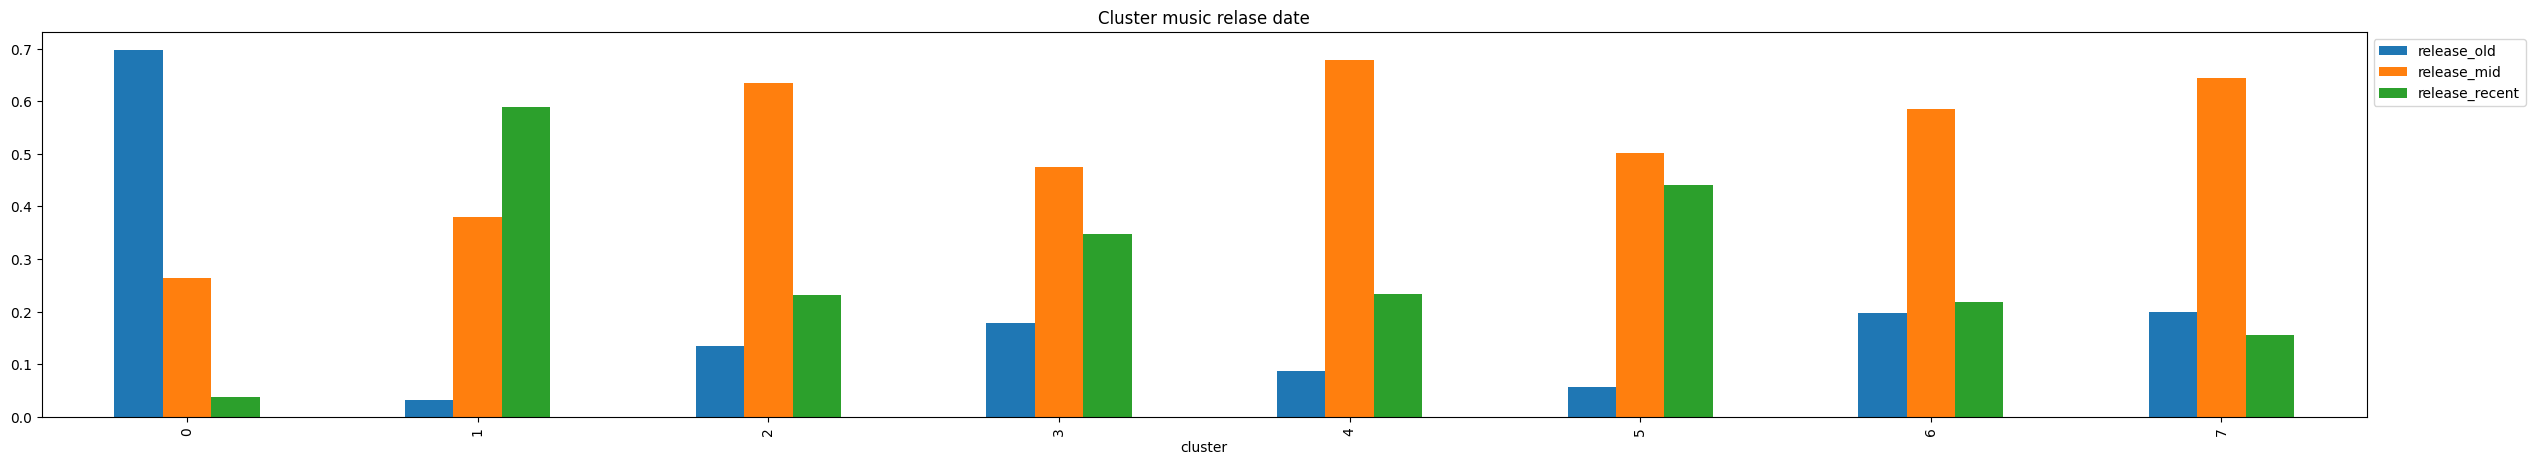

In [24]:
print(cluster_means[cluster_means.columns[21:24]])

# We can also compare the clusters to each other by creating a plot of the cluster means
# This can help us to see how the clusters differ from each other
cluster_means[cluster_means.columns[21:24]].plot(kind='bar')
plt.title('Cluster music relase date')
plt.legend(bbox_to_anchor=(1.0, 1.0))

plt.rcParams['figure.figsize'] = [30, 5]
plt.show()

In [25]:
df_playlist[df_playlist['cluster']==7].sort_values('playlist_num_followers', ascending=False)

,playlist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,Reggae/Dub,Rock/Metal,World Music,release_old,release_mid,release_recent,playlist_name,playlist_num_followers,playlist_num_tracks,cluster
202,1z1etSWezialaf7oEwd5Hq,-0.285028,0.663715,0.505062,0.304232,-0.568167,-0.255388,0.535340,0.358217,0.952310,...,0.0,0.25,0.0,0.05,0.75,0.20,ADHD Cleaning Playlist (154+ BPM),2229,36,7
611,5fpyzCQoqz7X182tihoulm,-0.051692,0.580690,-0.036567,-0.508175,-0.524671,-0.124393,-0.099330,0.713540,0.347041,...,0.0,0.60,0.0,0.25,0.75,0.00,80s Movie Songs,1377,221,7
689,6NmxuJUaU7CvfkCnFUNdOG,-0.350045,0.508329,0.671764,0.494604,-0.558301,-0.108683,-0.063552,0.122247,0.827121,...,0.0,0.20,0.0,0.05,0.55,0.40,POV: You're cleaning your room,953,74,7
520,4nCvINysMTTz4UobikjOPS,-0.355326,0.897047,0.523790,-0.257688,-0.600722,0.346318,0.055142,0.345797,0.357182,...,0.0,0.25,0.0,0.10,0.80,0.10,songs that instantly make you want to dance around the room by yourself like a crazy person,306,67,7
51,0eU6YrEBxh3WuRzVidiNbC,-0.290969,0.304448,0.387249,-0.285223,-0.438934,-0.285993,0.265244,-0.095410,0.277317,...,0.0,0.40,0.0,0.15,0.85,0.00,Spring Cleaning Motivational Songs,298,47,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,3ew1wPG9unakndo6OmxAPs,0.152600,0.596432,0.477303,0.341440,-0.531881,-0.184116,0.340860,-0.112881,0.104534,...,0.0,0.30,0.0,0.00,0.70,0.30,Cleaning Mix,0,291,7
368,3NKTcaWi5NdubiB76BaBp3,-0.302520,0.316128,0.379731,0.082111,0.041680,-0.292497,0.003367,-0.166769,0.479897,...,0.0,0.30,0.0,0.00,0.55,0.45,💯Chores playlist💯,0,133,7
356,3Iht4LCb2r2JEWOJz7TOaL,-1.186357,0.251891,-0.086465,-0.409606,-0.346138,1.749276,-0.184599,-0.992748,-0.097903,...,0.0,0.90,0.0,0.00,1.00,0.00,Chores,0,46,7
325,37i9dQZF1EIcI4S5xBp4fP,0.032467,0.763751,0.642196,-0.356435,-0.732154,-0.269320,0.002992,0.487885,0.290536,...,0.0,0.35,0.0,0.00,0.85,0.15,Cleaning Alternative Mix,0,50,7
